# Labels Profiling
This notebook shows a preliminary exploration of the labels, written with the COCO Keypoint 1.0 format.<br>
In this format we have a number for the class, that is always 0 because we care only about foosball tables, 4 numbers for the bounding box (coordinates for the center, width and height) and the variuos keypoints rapresented as (x, y, v), where x and y are simply the coordinates and v is the visibility (2 means visible, 1 means not visible and 0 means not present).

For a foosball table we have 8 keypoints: the first 4 form the upper rectangle, and the last 4 form the lower rectangle (the play area)<br>
We also need the upper rectangle because in some images, some vertices of the lower rectangle are cut out from the image, and so we will use the upper rectangle to build the lower rectangle.

## Setup
Execute this cell before the other ones.

In [25]:
import os
import sys
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
sys.path.append(str(Path("../src").resolve()))
from config import *

def load_dataframe():
    '''
    Load the main dataframe that will contain for every image the following informations:
    - visibility for each point
    - center: the center of the foosball table
    - direction: the normalized direction where the foosball table aim
    - dimension: the percentage of the image that is covered by the bounding box
    '''
    data = []
    for file in os.listdir(os.path.join(ROOT_DIRECTORY_FROM_NOTEBOOKS, LABELS_DIRECTORY)):
        if file.endswith(LABELS_EXTENSION):

            with open(os.path.join(ROOT_DIRECTORY_FROM_NOTEBOOKS, LABELS_DIRECTORY, file)) as label:
                content = label.readline()

            numbers = [float(x) for x in content[1:].split()]  # we ignore the first number that is always 0, because we only have one class, the foosball table

            # WARNING: we have to convert the position from the image coordinate system to a coordinate system more readable
            
            # the bounding box is rapresented as x and y of the center of the rectangle, and width and height of the rectangle
            bounding_box = (numbers[0], 1.0 - numbers[1], numbers[2], numbers[3])
            
            # the keypoint are rapresente as x, y and visibility (2: visible, 1: not visible, 0: not present)
            keypoints = []
            for i in range(4, 28, 3):
                keypoints.append((numbers[i], 1.0 - numbers[i+1], int(numbers[i+2])))

            # let's calculate the dimension: how much the bounding box covers the image
            dimension = bounding_box[2] * bounding_box[3]

            # let's calculate the center of the foosball table
            # for simplicity, we consider the center of the upper rectangle as the center of the foosball table

            # intersection between the line (keypoints[0], keypoints[2]) and the line (keypoints[1], keypoints[3])
            def calculate_intersection(line1, line2):
                '''
                ...
                '''
                x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
                y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

                def determinant(a, b):
                    return a[0] * b[1] - a[1] * b[0]

                divisor = determinant(x_diff, y_diff)
                if divisor == 0:
                    raise ValueError('The lines do not intersect.')

                d = (determinant(*line1), determinant(*line2))
                x = determinant(d, x_diff) / divisor
                y = determinant(d, y_diff) / divisor
                return [x, y]
            

            center = calculate_intersection([keypoints[0][0:2], keypoints[2][0:2]], [keypoints[1][0:2], keypoints[3][0:2]])

            # let's calculate the normalized direction of the foosball table
            # for simplicity, we consider the first 2 keypoints of the upper rectangle as the reference for the direction

            # we find the average point between keypoints[0] and keypoint[1]
            average_point = [(keypoints[0][0] + keypoints[1][0]) / 2.0, (keypoints[0][1] + keypoints[1][1]) / 2.0]
            
            # the direction from center to average_point is average_point - center
            direction = [average_point[0] - center[0], average_point[1] - center[1]]
            direction = direction / np.linalg.norm(direction)
            
            
            data.append({
                "filename": file,
                "center": center,
                "direction": direction,
                "dimension": dimension,
            })
            

    return pd.DataFrame(data)

df = load_dataframe()


## Centers and Directions Analysis

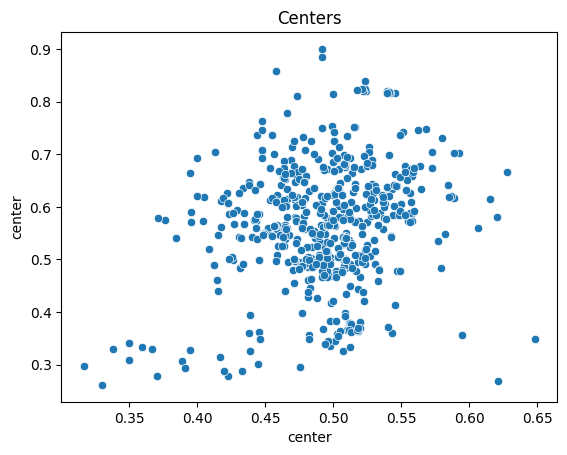

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df, x=df['center'].str[0], y=df['center'].str[1])
plt.title("Centers")
plt.show()


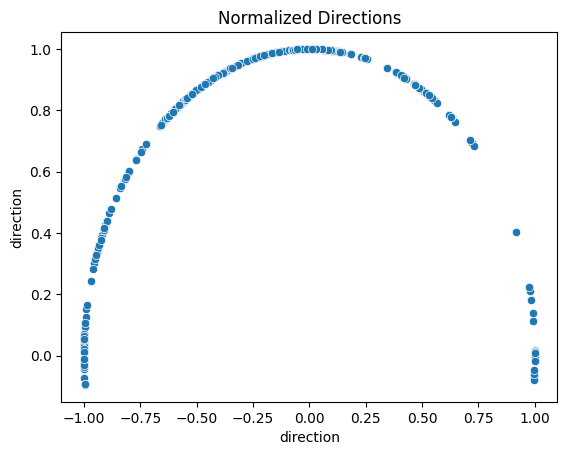

In [27]:
sns.scatterplot(data=df, x=df['direction'].str[0], y=df['direction'].str[1])
plt.title("Normalized Directions")
plt.show()

In [28]:
'''
query to remove
filtered = df[
    df['direction'].apply(lambda d: 0.5 <= d[0] <= 1.0 and 0.0 <= d[1] <= 0.5)
]

# restituisco solo i filename
result = filtered['filename'].tolist()
print(len(result))
for r in result:
    print(r)
'''


"\nquery to remove\nfiltered = df[\n    df['direction'].apply(lambda d: 0.5 <= d[0] <= 1.0 and 0.0 <= d[1] <= 0.5)\n]\n\n# restituisco solo i filename\nresult = filtered['filename'].tolist()\nprint(len(result))\nfor r in result:\n    print(r)\n"